<a href="https://colab.research.google.com/github/NeilMitra/2WD-ObstacleAvoidingRobot/blob/master/Base_Alpha_Capital_Markets_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
# ------------------------------------------------------------
# 0) Install/upgrade yfinance once per kernel if needed
# ------------------------------------------------------------
# %pip install -q --upgrade yfinance seaborn  # uncomment in Colab

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

# ------------------------------------------------------------
# 1) User parameters
# ------------------------------------------------------------
SYMBOL_SECURITY = "QQQ"    # equity / index ETF
SYMBOL_STRATEGY = "^VIX"   # volatility index
START_DATE      = "2020-01-01"
END_DATE        = "2025-01-30"

# ------------------------------------------------------------
# 2) Download *Close* prices (works whether auto_adjust is True or False)
# ------------------------------------------------------------
def fetch_close(ticker: str) -> pd.Series:
    data = yf.download(ticker,
                       start=START_DATE,
                       end=END_DATE,
                       auto_adjust=True,   # default is already True in new yfinance
                       progress=False)
    # If data come back in a MultiIndex (rare for single tickers), pick the correct slice
    if isinstance(data.columns, pd.MultiIndex):
        return data['Close', ticker]
    return data['Close']

sec_px = fetch_close(SYMBOL_SECURITY).rename("security")
str_px = fetch_close(SYMBOL_STRATEGY).rename("strategy")

df = pd.concat([sec_px, str_px], axis=1).dropna()
print(f"Downloaded {len(df):,d} rows from {df.index.min().date()} to {df.index.max().date()}")
df.head()


Downloaded 1,276 rows from 2020-01-02 to 2025-01-29


,security,strategy
Date,,
2020-01-02,209.325882,12.47
2020-01-03,207.408463,14.02
2020-01-06,208.744873,13.85
2020-01-07,208.715820,13.79
2020-01-08,210.284592,13.45


In [60]:
# ------------------------------------------------------------
# 3) Strategy hyper‑parameters (edit here)
# ------------------------------------------------------------
BETA_LOOKBACK  = 252      # days for hedge‑ratio regression
STAT_LOOKBACK  = 60       # days for spread μ/σ
ENTRY_Z        = 1.0      # threshold
COST_PER_LEG   = 0.001    # 10 bp per leg
ANNUAL_FACTOR  = 252

# ------------------------------------------------------------
# 4) Expand‑window µ/σ for z‑scoring (no look‑ahead)
# ------------------------------------------------------------
mu_strategy = df['strategy'].expanding().mean().shift(1)
sd_strategy = df['strategy'].expanding().std().shift(1)
mu_security = df['security'].expanding().mean().shift(1)
sd_security = df['security'].expanding().std().shift(1)

df['strategy_z'] = (df['strategy'] - mu_strategy) / sd_strategy
df['security_z'] = (df['security'] - mu_security) / sd_security

# ------------------------------------------------------------
# 5) Rolling hedge‑ratio β(t) with one‑bar lag
# ------------------------------------------------------------
beta = np.full(len(df), np.nan)

for i in range(BETA_LOOKBACK, len(df)):
    y = df['strategy_z'].iloc[i-BETA_LOOKBACK:i]
    x = df['security_z'].iloc[i-BETA_LOOKBACK:i]
    beta[i] = np.cov(y, x)[0, 1] / np.var(x) if np.var(x) != 0 else 0.0

df['beta'] = pd.Series(beta, index=df.index).shift(1)
df.dropna(subset=['beta'], inplace=True)  # trim early rows

# ------------------------------------------------------------
# 6) Spread, z‑score, and trading signals
# ------------------------------------------------------------
df['spread'] = df['strategy_z'] - df['beta'] * df['security_z']

df['spread_mean'] = (
    df['spread'].rolling(STAT_LOOKBACK, min_periods=STAT_LOOKBACK).mean().shift(1)
)
df['spread_std'] = (
    df['spread'].rolling(STAT_LOOKBACK, min_periods=STAT_LOOKBACK).std().shift(1)
)
df.dropna(subset=['spread_mean', 'spread_std'], inplace=True)

df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

df['long_signal']  = df['zscore'] < -ENTRY_Z
df['short_signal'] = df['zscore'] >  ENTRY_Z
df['exit_signal']  = (df['zscore'] * df['zscore'].shift(1) < 0)

# position building
position, pos_series = 0, []
for long_sig, short_sig, exit_sig in zip(df['long_signal'],
                                         df['short_signal'],
                                         df['exit_signal']):
    if position == 0:
        position =  1 if long_sig  else -1 if short_sig else 0
    elif exit_sig:
        position = 0
    pos_series.append(position)
df['position'] = pos_series

# ------------------------------------------------------------
# 7) Daily P&L with realistic trading costs
# ------------------------------------------------------------
ret_strat   = df['strategy'].pct_change()
ret_sec     = df['security'].pct_change()
df['spread_ret'] = ret_strat - df['beta'] * ret_sec

df['gross_rtn'] = df['position'].shift() * df['spread_ret']
df['turnover']  = df['position'].diff().abs()        # 0,1,2
df['cost']      = df['turnover'] * (2 * COST_PER_LEG)
df['net_rtn']   = df['gross_rtn'] - df['cost']
df['cum_net']   = (1 + df['net_rtn'].fillna(0)).cumprod()

display(df[['strategy', 'security', 'beta', 'zscore', 'position']].tail())

,strategy,security,beta,zscore,position
Date,,,,,
2025-01-23,15.020000,531.846863,-0.907056,1.589791,-1
2025-01-24,14.850000,528.841370,-0.911285,1.458099,-1
2025-01-27,17.900000,513.444336,-0.915434,1.684500,-1
2025-01-28,16.410000,521.033020,-0.920285,1.495524,-1
2025-01-29,16.559999,520.054504,-0.924528,1.455341,-1


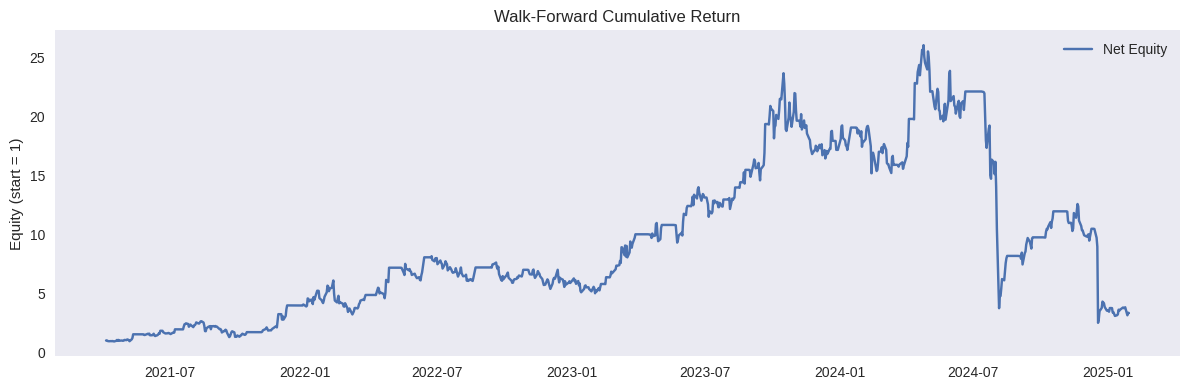

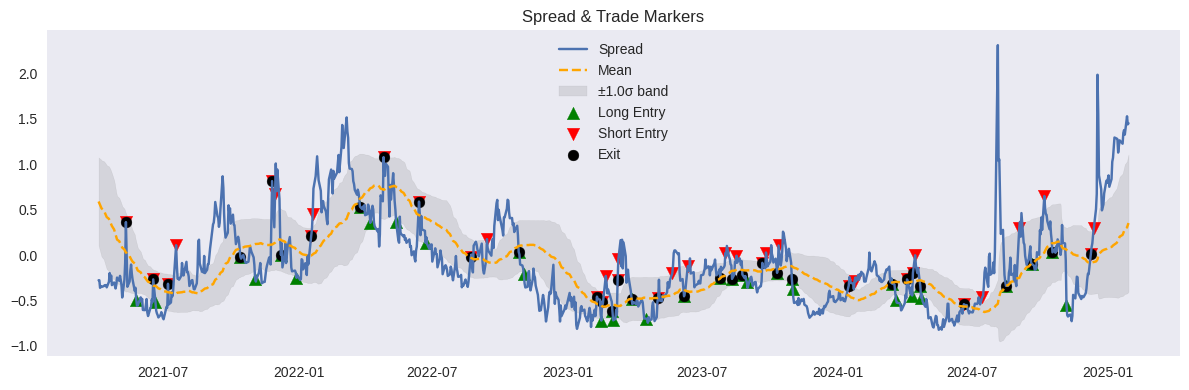

In [61]:
# ------------------------------------------------------------
# 8) Equity curve
# ------------------------------------------------------------
plt.figure(figsize=(12,4))
plt.plot(df.index, df['cum_net'], label='Net Equity')
plt.title('Walk‑Forward Cumulative Return')
plt.ylabel('Equity (start = 1)')
plt.grid(); plt.legend(); plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 9) Spread with entry/exit markers
# ------------------------------------------------------------
plt.figure(figsize=(12,4))
plt.plot(df.index, df['spread'], label='Spread')
plt.plot(df.index, df['spread_mean'], '--', color='orange', label='Mean')
plt.fill_between(df.index,
                 df['spread_mean'] + ENTRY_Z*df['spread_std'],
                 df['spread_mean'] - ENTRY_Z*df['spread_std'],
                 alpha=0.2, color='gray', label=f'±{ENTRY_Z}σ band')

long_ent  = df['position'].diff() ==  1
short_ent = df['position'].diff() == -1
exits     = df['position'].diff().abs() == 1

plt.scatter(df.index[long_ent],  df['spread'][long_ent],
            marker='^', s=80, color='green',  label='Long Entry')
plt.scatter(df.index[short_ent], df['spread'][short_ent],
            marker='v', s=80, color='red',    label='Short Entry')
plt.scatter(df.index[exits & (df['position'] == 0)], df['spread'][exits & (df['position'] == 0)],
            marker='o', s=60, color='black', label='Exit')
plt.title('Spread & Trade Markers')
plt.legend(); plt.grid(); plt.tight_layout()
plt.show()


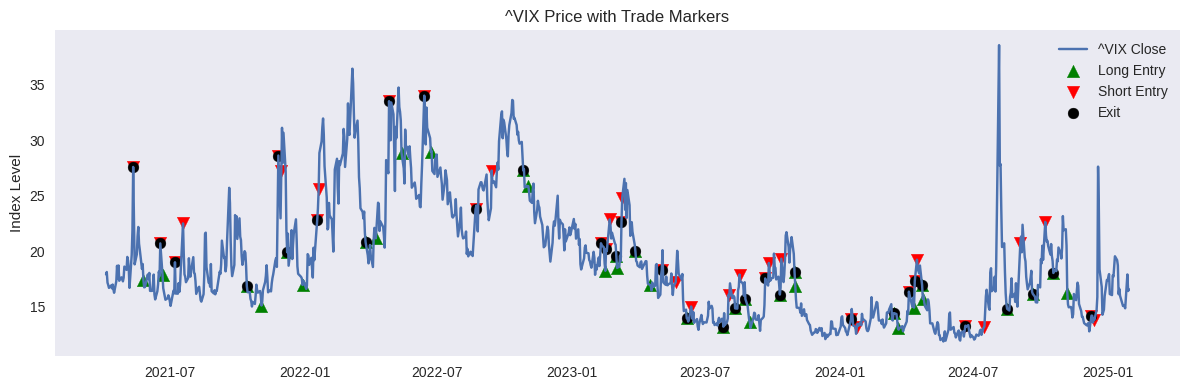

In [62]:
# ------------------------------------------------------------
# 9b) VIX price with entry/exit markers
# ------------------------------------------------------------
plt.figure(figsize=(12,4))
plt.plot(df.index, df['strategy'], label=f'{SYMBOL_STRATEGY} Close')

# Re‑use the position changes to locate trades
long_ent_mask   = df['position'].diff() ==  1   # open long‑spread  → long VIX
short_ent_mask  = df['position'].diff() == -1   # open short‑spread → short VIX
exit_mask       = (df['position'].diff().abs() == 1) & (df['position'] == 0)

plt.scatter(df.index[long_ent_mask],  df['strategy'][long_ent_mask],
            marker='^', s=80, color='green',  label='Long Entry')
plt.scatter(df.index[short_ent_mask], df['strategy'][short_ent_mask],
            marker='v', s=80, color='red',    label='Short Entry')
plt.scatter(df.index[exit_mask],       df['strategy'][exit_mask],
            marker='o', s=60, color='black', label='Exit')

plt.title(f'{SYMBOL_STRATEGY} Price with Trade Markers')
plt.ylabel('Index Level')
plt.legend(); plt.grid(); plt.tight_layout()
plt.show()


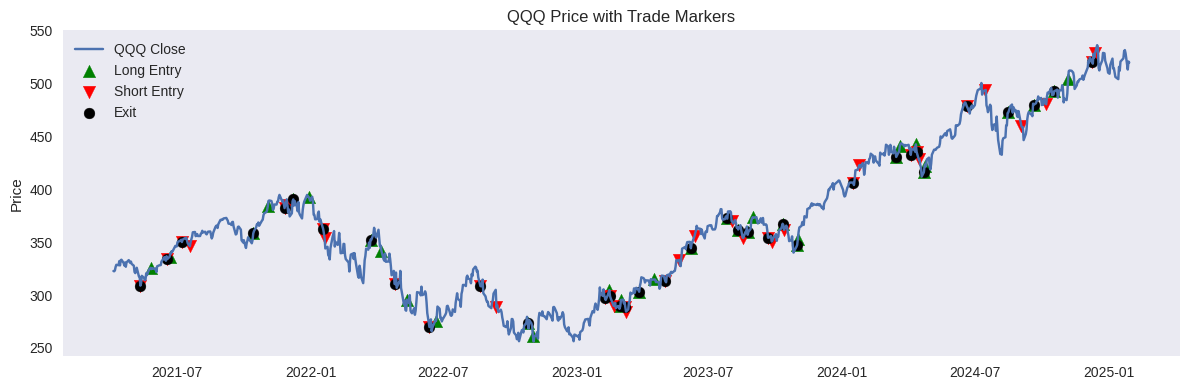

In [63]:
# ------------------------------------------------------------
# 9c) QQQ price with entry/exit markers
# ------------------------------------------------------------
plt.figure(figsize=(12,4))
plt.plot(df.index, df['security'], label=f'{SYMBOL_SECURITY} Close')

# Re‑use the same masks
plt.scatter(df.index[long_ent_mask],  df['security'][long_ent_mask],
            marker='^', s=80, color='green',  label='Long Entry')
plt.scatter(df.index[short_ent_mask], df['security'][short_ent_mask],
            marker='v', s=80, color='red',    label='Short Entry')
plt.scatter(df.index[exit_mask],       df['security'][exit_mask],
            marker='o', s=60, color='black', label='Exit')

plt.title(f'{SYMBOL_SECURITY} Price with Trade Markers')
plt.ylabel('Price')
plt.legend(); plt.grid(); plt.tight_layout()
plt.show()


In [64]:
# ------------------------------------------------------------
# 10) Trade log
# ------------------------------------------------------------
df['pos_shift'] = df['position'].shift()
trades = df[df['position'] != df['pos_shift']].copy()
trades['type'] = trades['position'].map({ 1: 'Long Entry',
                                         -1: 'Short Entry',
                                          0: 'Exit'})
trades['pnl']  = df['net_rtn']
trades = trades[['type', 'strategy', 'security', 'beta', 'zscore', 'pnl']]
display(trades.head(10))

# ------------------------------------------------------------
# 11) Quick summary stats
# ------------------------------------------------------------
ann_ret = df['net_rtn'].mean()*ANNUAL_FACTOR
ann_vol = df['net_rtn'].std()*np.sqrt(ANNUAL_FACTOR)
sharpe  = ann_ret / ann_vol if ann_vol else np.nan
max_dd  = (df['cum_net'].cummax() - df['cum_net']).max()
trade_count = int(df['turnover'].sum())

summary = pd.DataFrame({
    'Annual Return'    : [f"{ann_ret:.2%}"],
    'Annual Volatility': [f"{ann_vol:.2%}"],
    'Sharpe Ratio'     : [round(sharpe, 2)],
    'Max Drawdown'     : [f"{max_dd:.2%}"],
    'Trades Executed'  : [trade_count]
})
display(summary)


,type,strategy,security,beta,zscore,pnl
Date,,,,,,
2021-04-05,Long Entry,17.910000,322.815979,-0.390421,-1.789427,NaN
2021-05-12,Exit,27.590000,309.008118,-0.318333,0.775249,0.253039
2021-05-26,Long Entry,17.360001,325.819336,-0.273953,-1.297980,-0.002000
2021-06-18,Exit,20.700001,334.107849,-0.180884,0.393550,0.162778
2021-06-21,Long Entry,17.889999,336.184357,-0.180269,-1.009625,-0.002000
2021-07-08,Exit,19.000000,350.252289,-0.199234,0.472331,0.169636
2021-07-19,Short Entry,22.500000,346.249603,-0.278260,2.661686,-0.002000
2021-10-14,Exit,16.860001,358.322510,-0.550330,-0.294289,0.083358
2021-11-03,Long Entry,15.100000,384.270874,-0.372949,-1.346348,-0.002000


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown,Trades Executed
0,96.08%,103.20%,0.93,2353.14%,70


In [65]:
# ============================================================
# 12) Extended Metrics – robust naming
# ============================================================
import statsmodels.api as sm

BENCH_TICKER   = "QQQ"
RISK_FREE_ANN  = 0.03
CONF_LEVEL     = 0.95
ANNUAL_FACTOR  = 252

# ---------- benchmark ----------
bench_px = yf.download(
    BENCH_TICKER,
    start=df.index.min(),
    end=df.index.max() + pd.Timedelta(days=1),
    auto_adjust=True,
    progress=False
)['Close']

bench_ret = bench_px.pct_change().reindex(df.index).fillna(0)

# ---------- excess returns ----------
daily_rf = RISK_FREE_ANN / ANNUAL_FACTOR
ex_strat = df['net_rtn'] - daily_rf
ex_bench = bench_ret      - daily_rf
ex_bench.name = "bench"          # <‑‑‑ give it a stable name

# align & drop NaN
aligned = pd.concat([ex_strat, ex_bench], axis=1).dropna()
ex_strat, ex_bench = aligned.iloc[:,0], aligned.iloc[:,1]

# ---------- alpha / beta ----------
X        = sm.add_constant(ex_bench)
abt      = sm.OLS(ex_strat, X).fit()

beta_col = [c for c in abt.params.index if c != "const"][0]
alpha_ann = float(abt.params["const"] * ANNUAL_FACTOR)
beta_mkt  = float(abt.params[beta_col])
r_squared = float(abt.rsquared)
corr      = float(ex_strat.corr(ex_bench))

# ---------- ratios ----------
ann_excess = float(ex_strat.mean() * ANNUAL_FACTOR)
ann_vol    = float(ex_strat.std()  * np.sqrt(ANNUAL_FACTOR))
sharpe     = ann_excess / ann_vol if ann_vol else np.nan

treynor    = ann_excess / beta_mkt if beta_mkt else np.nan

diff_ret   = ex_strat - ex_bench
info_ratio = float(diff_ret.mean() / diff_ret.std() * np.sqrt(ANNUAL_FACTOR))

downside_std = ex_strat[ex_strat < 0].std() * np.sqrt(ANNUAL_FACTOR)
sortino      = ann_excess / downside_std if downside_std else np.nan

var_cut  = 1 - CONF_LEVEL
var_95   = float(ex_strat.quantile(var_cut))
cvar_95  = float(ex_strat[ex_strat < var_95].mean())

max_dd   = (df['cum_net'].cummax() - df['cum_net']).max()
calmar   = ann_excess / max_dd if max_dd else np.nan

gross_gain = df['net_rtn'][df['net_rtn'] > 0].sum()
gross_loss = df['net_rtn'][df['net_rtn'] < 0].abs().sum()
profit_factor = gross_gain / gross_loss if gross_loss else np.nan
win_rate      = float((df['net_rtn'] > 0).mean() * 100)

avg_hold = (
    df['position'].ne(0)
      .astype(int)
      .groupby((df['position'] != df['position'].shift()).cumsum())
      .sum()
      .mean()
)

# ---------- table ----------
hf_metrics = pd.DataFrame({
    'Alpha (Ann.)'      : [round(alpha_ann,   4)],
    'Beta'              : [round(beta_mkt,    4)],
    'R‑squared'         : [round(r_squared,   4)],
    'Correlation'       : [round(corr,        4)],
    'Sharpe Ratio'      : [round(sharpe,      2)],
    'Sortino Ratio'     : [round(sortino,     2)],
    'Treynor Ratio'     : [round(treynor,     2)],
    'Information Ratio' : [round(info_ratio,  2)],
    'VaR (95 %)'        : [round(var_95,      4)],
    'CVaR (95 %)'       : [round(cvar_95,     4)],
    'Calmar Ratio'      : [round(calmar,      2)],
    'Profit Factor'     : [round(profit_factor, 2)],
    'Win Rate (%)'      : [round(win_rate,    2)],
    'Trades Executed'   : [int(df["turnover"].sum())],
    'Avg Hold (days)'   : [round(avg_hold, 1)]
})

display(hf_metrics.style.set_caption("Extended Performance Metrics"))


,Alpha (Ann.),Beta,R‑squared,Correlation,Sharpe Ratio,Sortino Ratio,Treynor Ratio,Information Ratio,VaR (95 %),CVaR (95 %),Calmar Ratio,Profit Factor,Win Rate (%),Trades Executed,Avg Hold (days)
0,0.887200,0.363100,0.006100,0.078400,0.900000,1.110000,2.560000,0.780000,-0.078000,-0.142400,0.040000,1.230000,39.850000,70,10.400000
